In [1]:
# pip install matplotlib

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from physvae import utils
from physvae.advdif.model import VAE

In [3]:
# setting
datadir = './data/advdif'
dataname = 'test'
modeldir = './out_advdif/'

In [4]:
# load data
data_test = np.load('{}/data_{}.npy'.format(datadir, dataname))

In [5]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set and load model
with open('{}/args.json'.format(modeldir), 'r') as f:
    args_tr_dict = json.load(f)
model = VAE(args_tr_dict).to(device)
model.load_state_dict(torch.load('{}/model.pt'.format(modeldir), map_location=device))
model.eval()
dim_x = args_tr_dict['dim_x']
dim_t_tr = args_tr_dict['dim_t']
dx = args_tr_dict['dx']
dt = args_tr_dict['dt']
print('model loaded')

model loaded


In [6]:
# infer latent variables using short data
data_tensor = torch.Tensor(data_test).to(device).view(-1,dim_x,dim_t_tr)

with torch.no_grad():
    # aux only
    z_phy_stat, z_aux1_stat, z_aux2_stat, unmixed = model.encode(data_tensor)
    z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat, hard_z=False)

In [7]:
# change model's integrator setting
model.len_intg = (1000 - 1) * model.intg_lev + 1
model.t_intg = torch.linspace(0.0, model.dt_intg*(model.len_intg-1), model.len_intg)

# reconstruction with extrapolation
dim_t_te = data_test.shape[-1]
data_tensor = torch.Tensor(data_test).to(device).view(-1,dim_x,dim_t_te)
with torch.no_grad():
    init_y = data_tensor[:,:,0].clone()
    x_full, _, _, _, _ = model.decode(z_phy, z_aux1, z_aux2, init_y, full=True)

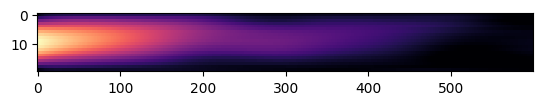

In [8]:
# plot
idx = 78
showlen = 600

vmax = data_test[idx].max()
kwargs = {'vmin':0.0, 'vmax':vmax, 'aspect':3.5, 'cmap':'magma', 'interpolation':'none'}

plt.figure()
plt.imshow(x_full[idx,:,0:showlen].cpu(), **kwargs)
plt.show()